In [1]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import chardet
import glob
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
import sys
import cfunits

# import custom modules
sys.path.append('../scripts')
import funcs

---
---
# Table of contents
* [1. Load source data](#load-data)
    * [1.1. Preview headers](#preview-headers)  
* [2. Prepare data headers](#prep-headers)
    * [2.1. Preview headers, descriptions, and units](#view-headers)
    * [2.2. Clean headers, descriptions, and units](#clean-headers)
        * [2.2.1. Units (multi-header index 2)](#units)
        * [2.2.2. Descriptions (multi-header index 1)](#descriptions)
        * [2.2.3. Variables (multi-header index 0)](#variables)
        * [2.2.4. Data values](#data-vals)
* [3. Standardize data headers](#standardizing-steps)
    * [3.1. Copy of filename_headers to filename_headers_lookup](#copy)
    * [3.2. Assign lookup table header names](#assign)
    * [3.3. Use ESS-Dive leaf-gas-exchange standards to create lookup table](#multiheader-standards)
    * [3.4. Load the lookup table](#complete-lookup)
    * [3.5. Use the lookup table to standardize headers](#standardize)
* [4. Data quality control](#qc)
    * [4.1. Strings](#strings)
    * [4.2. Measurememt device](#device)
    * [4.3. Season](#season)
    * [4.4. Plant height](#height)
    * [4.5. Datetimes](#datetimes)
    * [4.6. Species names](#species)
    * [4.7. Create species lookup table](#species-lookup)
    * [4.8. Fill in species lookup table](#fill-species-lookup)
        * [4.8.1. Format headers](#species-lookup-headers)
        * [4.8.2. Merge lookup table with data](#merge)
        * [4.8.3. Drop extra columns](#drop)
* [5. Data unit conversion](#unit-conversion)
    * [5.1. Visualize and confirm unit conversions](#confirm-conversion)
    * [5.2. Drop out-of-range (oor) values](#oor)

---
---
## 1. Load the data <a class="anchor" id="load-data"></a>
NOTE: If certain fancy characters aren't used in a file, an encoder will pick it up as us/ascii even if I've explicitly encoded it as utf-8-sig, and that's fine. UTF-8-SIG just ensures that the .csv is read properly in Excel on a Mac AND a windows computer.

In [2]:
filename = 'rogers_2017'
data_dir_path = f'../data/input/{filename}'

In [3]:
# # ensure encoding of individual ACI curve files
# for f in os.listdir(data_dir_path):
#     if f.endswith(".csv"):
#         original_file_path = os.path.join(data_dir_path, f)
#         funcs.convert_to_utf8sig(original_file_path)

In [4]:
# data paths
utf8_data_path = f'{data_dir_path}/2017_SLZ_ACi_comp.csv'
utf8_metadata_path = f'{data_dir_path}/2017_SLZ_ACi_comp_DCD.csv'

# read the data
data = pd.read_csv(utf8_data_path)

# read the metadata
metadata = pd.read_csv(utf8_metadata_path)

---
### 1.1. Preview the data and metadata headers <a class="anchor" id="preview-headers"></a>
If there are no metadata provided, you must create a metadata .csv based on the headers in the data

In [5]:
data.columns

Index(['Site', 'Species', 'Sample_ID', 'YYYYMMDD', 'HHMMSS', 'Branch_Number',
       'Leaf_Age', 'Leaf_Age_Revised', 'Machine_name', 'Serial', 'QC', 'Obs',
       'Tleaf', 'Photo', 'Ci', 'CO2S', 'VpdA', 'RH_S', 'Tair', 'PARi', 'Press',
       'Cond', 'BLCond', 'Trmmol', 'FTime', 'Ebal', 'VpdL', 'CTleaf', 'Area',
       'BLC_1', 'StmRat', 'TBlk', 'CO2R', 'H2OR', 'H2OS', 'RH_R', 'Flow',
       'PARo', 'CsMch', 'HsMch', 'StableF', 'BLCslope', 'BLCoffst', 'f_parin',
       'f_parout', 'alphaK', 'Status', 'fda', 'Trans', 'Tair_K', 'Twall_K',
       'R_W_m2', 'Tl_minus_Ta', 'SVTleaf', 'h2o_i', 'h20diff', 'CTair',
       'SVTair', 'CndTotal', 'vp_kPa', 'CndCO2', 'Ci_Pa', 'Ci_Ca', 'RHsfc',
       'C2sfc', 'AHs_Cs'],
      dtype='object')

In [6]:
# this is how the metadata file should be structured before reading it: variable, description, units
# this may have to be created or edited manually before reading it here
metadata = metadata.rename(columns={'Datafile_ColumnName':'variable', 
                                    'Datafile_Units':'unit', 
                                    'Datafile_Measure':'description'})
metadata

,variable,description,unit
0,Site,Canopy crane location,text
1,Species,STRI species code,alphanumeric
2,Sample_ID,sample number,alphanumeric
3,YYYYMMDD,Measurement date,numeric
4,HHMMSS,Measurement local time,numeric
...,...,...,...
61,Ci_Pa,Intercellular CO2,Pa
62,Ci/Ca,Intercellular CO2 / Ambient CO2,numeric ratio
63,RHsfc,Surface humidity,numeric percentage
64,C2sfc,Surface CO2,μmol mol-1


---
---
## 2. Prepare data headers <a class="anchor" id="prep-headers"></a>
Add variable/description/units to as a 3-row multi-header

In [7]:
# merge metadata with data column names
columns_df = pd.DataFrame({'variable': data.columns})
matched_metadata = columns_df.merge(metadata, on='variable', how='left')

# check for unmatched variables
unmatched = matched_metadata[matched_metadata['description'].isnull()]
if not unmatched.empty:
    print("Warning: Some columns in the data file do not match the metadata:")
    print(unmatched)

       variable description unit
25         Ebal         NaN  NaN
51       R_W_m2         NaN  NaN
52  Tl_minus_Ta         NaN  NaN
62        Ci_Ca         NaN  NaN
65       AHs_Cs         NaN  NaN


In [8]:
# Fix issues found above
metadata = metadata.replace({'EBal?':'Ebal',
                             'R(W/m2)':'R_W_m2',
                             'Tl-Ta':'Tl_minus_Ta',
                             'Ci/Ca':'Ci_Ca',
                             'AHs/Cs':'AHs_Cs'})

In [9]:
# merge metadata with data column names
columns_df = pd.DataFrame({'variable': data.columns})
matched_metadata = columns_df.merge(metadata, on='variable', how='left')

# check for unmatched variables
unmatched = matched_metadata[matched_metadata['description'].isnull()]
if not unmatched.empty:
    print("Warning: Some columns in the data file do not match the metadata:")
    print(unmatched)

In [10]:
# drop unmatched variables
matched_metadata = matched_metadata.dropna(subset=['variable'])
data = data[matched_metadata['variable'].tolist()]

# create the description and unit rows
description_row = matched_metadata['description'].tolist()
unit_row = matched_metadata['unit'].tolist()
data_with_metadata = pd.concat(
    [pd.DataFrame([description_row, unit_row], columns=data.columns), data],
    ignore_index=True)

# Set the multi-index
data_with_metadata.columns = pd.MultiIndex.from_arrays(
    [data.columns, description_row, unit_row],
    names=['variable', 'description', 'unit'])
data_with_metadata = data_with_metadata.iloc[2:]

In [11]:
# replace data dataframe with the one with metadata
data = data_with_metadata.iloc[2:].copy()
data

variable,Site,Species,Sample_ID,YYYYMMDD,HHMMSS,Branch_Number,Leaf_Age,Leaf_Age_Revised,Machine_name,Serial,...,CTair,SVTair,CndTotal,vp_kPa,CndCO2,Ci_Pa,Ci_Ca,RHsfc,C2sfc,AHs_Cs
description,Canopy crane location,STRI species code,sample number,Measurement date,Measurement local time,Branch ID to differentiate branches of each species,Leaf age as assessed at time of sampling + Leaf count from youngest leaf on stem,Updated leaf age following reassessment against photographs + Leaf count from youngest leaf on stem,Licor 6400XT instrument name,Licor 6400XT instrument serial number,...,Computed chamber air temp,SatVap(Tair),Total conductance,vapor pressure chamber air,Total Conductance to CO2,Intercellular CO2,Intercellular CO2 / Ambient CO2,Surface humidity,Surface CO2,Ball-Berry parameter
unit,text,alphanumeric,alphanumeric,numeric,numeric,integer,alphanumeric,alphanumeric,text,alphanumeric,...,numeric,numeric,numeric,numeric,numeric,Pa,numeric ratio,numeric percentage,μmol mol-1,numeric
4,PA-SLZ,TERMAM,BNL11837,20170216,8:28:28,1,M2,M2,Mariano,PSC-0464,...,28.356964,3.87453,0.200272,3.001679,0.126452,18.280311,0.760298,76.841053,237.98952,0.022255
5,PA-SLZ,TERMAM,BNL11837,20170216,8:29:50,1,M2,M2,Mariano,PSC-0464,...,28.361144,3.875472,0.202453,3.009167,0.127843,13.415526,0.793715,77.029217,167.623377,0.019166
6,PA-SLZ,TERMAM,BNL11837,20170216,8:31:12,1,M2,M2,Mariano,PSC-0464,...,28.387931,3.881511,0.206393,3.02066,0.130357,8.649342,0.883591,77.164247,97.605067,0.010306
7,PA-SLZ,TERMAM,BNL11837,20170216,8:32:34,1,M2,M2,Mariano,PSC-0464,...,28.393629,3.882797,0.213735,3.032824,0.135046,6.417076,0.978322,77.519537,65.788707,0.000686
8,PA-SLZ,TERMAM,BNL11837,20170216,8:34:56,1,M2,M2,Mariano,PSC-0464,...,28.437509,3.892712,0.230368,3.061621,0.145679,4.556821,1.127306,78.104939,40.96034,-0.016144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,PA-SLZ,GUATDU,BNL12145,20170222,14:01:12,31,Y1,Y1,Derek,PSC-0570,...,29.932375,4.243929,0.246933,3.402782,0.156286,67.361114,0.86976,77.42878,774.330152,0.01389
1221,PA-SLZ,GUATDU,BNL12145,20170222,14:02:58,31,Y1,Y1,Derek,PSC-0570,...,29.915181,4.239737,0.243835,3.393303,0.154301,85.829341,0.883882,77.275124,972.053924,0.011949


---
### 2.1. Preview headers, descriptions, and units <a class="anchor" id="view-headers"></a>

In [12]:
data.columns.get_level_values(0)

Index(['Site', 'Species', 'Sample_ID', 'YYYYMMDD', 'HHMMSS', 'Branch_Number',
       'Leaf_Age', 'Leaf_Age_Revised', 'Machine_name', 'Serial', 'QC', 'Obs',
       'Tleaf', 'Photo', 'Ci', 'CO2S', 'VpdA', 'RH_S', 'Tair', 'PARi', 'Press',
       'Cond', 'BLCond', 'Trmmol', 'FTime', 'Ebal', 'VpdL', 'CTleaf', 'Area',
       'BLC_1', 'StmRat', 'TBlk', 'CO2R', 'H2OR', 'H2OS', 'RH_R', 'Flow',
       'PARo', 'CsMch', 'HsMch', 'StableF', 'BLCslope', 'BLCoffst', 'f_parin',
       'f_parout', 'alphaK', 'Status', 'fda', 'Trans', 'Tair_K', 'Twall_K',
       'R_W_m2', 'Tl_minus_Ta', 'SVTleaf', 'h2o_i', 'h20diff', 'CTair',
       'SVTair', 'CndTotal', 'vp_kPa', 'CndCO2', 'Ci_Pa', 'Ci_Ca', 'RHsfc',
       'C2sfc', 'AHs_Cs'],
      dtype='object', name='variable')

In [13]:
data.columns.get_level_values(1)

Index(['Canopy crane location', 'STRI species code', 'sample number',
       'Measurement date', 'Measurement local time',
       'Branch ID to differentiate branches of each species',
       'Leaf age as assessed at time of sampling + Leaf count from youngest leaf on stem',
       'Updated leaf age following reassessment against photographs + Leaf count from youngest leaf on stem',
       'Licor 6400XT instrument name', 'Licor 6400XT instrument serial number',
       'Quality control flag. 1 indicates poor data not used in model fit',
       'Licor log record number', 'Temperature of leaf thermocouple',
       'Photosynthetic rate', 'Intercellular CO2 concentration',
       'Sample cell CO2', 'Vapor pressure deficit based on Air temp',
       'Relative humidity in the sample cell (%)',
       'Temperature in sample cell', 'In-chamber quantum sensor',
       'Atmospheric pressure', 'Conductance to H2O',
       'Total boundary layer conductance for the leaf (includes stomatal ratio)',
 

In [14]:
data.columns.get_level_values(2)

Index(['text', 'alphanumeric', 'alphanumeric', 'numeric', 'numeric', 'integer',
       'alphanumeric', 'alphanumeric', 'text', 'alphanumeric', 'integer',
       'integer', 'degrees Celsius', 'μmol CO2 m-2 s-1', 'μmol CO2 mol-1',
       'μmol CO2 mol-1', 'kPa', 'numeric percentage', 'degrees Celsius',
       'μmol m-2 s-1', 'kPa', 'mol H2O m-2 s-1', 'mol m-2 s-1',
       'mmol H2O m-2 s-1)', 'numeric  ', 'integer', 'kPa', 'degrees Celsius',
       'cm2', 'numeric', 'numeric ratio', 'degrees Celsius', 'μmol CO2 mol-1',
       'mmol H2O mol-1', 'mmol H2O mol-1', 'numeric percentage', 'μmol s-1',
       'μmol m-2 s-1', 'μmol mol-1', 'mmol mol-1', 'numeric', 'numeric',
       'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric',
       'mol/m2/s', 'Kelvin', 'Kelvin', 'W/m2', 'numeric', 'numeric', 'numeric',
       'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'Pa',
       'numeric ratio', 'numeric percentage', 'μmol mol-1', 'numeric'],
      dtype='object', n

---
### 2.2. Clean headers, descriptions, and units <a class="anchor" id="clean-headers"></a>

#### 2.2.1. Units (multi-header index 2) <a class="anchor" id="units"></a>
Some examples of correct unit formats:
* mmol m-2 s-1
* m-2 s-1
* 1 (for unitless values or categorical data)
* degree_C
* degree (for decimal degrees)

In [15]:
# clean units using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(2)
cleaned_l2_values = funcs.clean_values(values)

# replace unclean units with cleaned units
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    data.columns.get_level_values(1),
    cleaned_l2_values
])

In [16]:
data.columns.get_level_values(2).unique()

Index(['text', 'alphanumeric', 'numeric', 'integer', 'degrees Celsius',
       'µmol CO2 m-2 s-1', 'µmol CO2 mol-1', 'kPa', 'numeric percentage',
       'µmol m-2 s-1', 'mol H2O m-2 s-1', 'mol m-2 s-1', 'mmol H2O m-2 s-1)',
       'cm2', 'numeric ratio', 'mmol H2O mol-1', 'µmol s-1', 'µmol mol-1',
       'mmol mol-1', 'mol/m2/s', 'Kelvin', 'W/m2', 'Pa'],
      dtype='object', name='unit')

In [17]:
replacement_l2_vals = {'text':1, 
                       'alphanumeric':1, 
                       'numeric':1, 
                       'integer':1, 
                       'degrees Celsius':'degree_C',
                       'µmol CO2 m-2 s-1':'µmol m-2 s-1', 
                       'µmol CO2 mol-1':'µmol mol-1',
                       'numeric percentage':'%',
                       'mol H2O m-2 s-1':'mol m-2 s-1', 
                       'mmol H2O m-2 s-1)':'mmol m-2 s-1',
                       'cm2':'cm-2', 
                       'numeric ratio':1, 
                       'mmol H2O mol-1':'mmol mol-1',
                       'mol/m2/s':'mol m-2 s-1', 
                       'Kelvin':'degree_K', 
                       'W/m2':'W m-2'}

In [18]:
# standardize level-2 (unit) values
# Get the levels from the MultiIndex
level_0 = data.columns.get_level_values(0)
level_1 = data.columns.get_level_values(1)
level_2 = data.columns.get_level_values(2).to_series().replace(replacement_l2_vals)

# Reassign the modified levels back to all_data.columns as a new MultiIndex
data.columns = pd.MultiIndex.from_arrays([level_0, level_1, level_2])

#### 2.2.2. Descriptions (multi-header index 1) <a class="anchor" id="descriptions"></a>

In [19]:
# clean descriptions using local modules in funcs.py: funcs.clean_values()
values = data.columns.get_level_values(1)
cleaned_l1_values = funcs.clean_values(values)

# replace unclean descriptions with cleaned descriptions
data.columns = pd.MultiIndex.from_arrays([
    data.columns.get_level_values(0),
    cleaned_l1_values,
    data.columns.get_level_values(2),
])

#### 2.2.3. Variables (multi-header index 0) <a class="anchor" id="variables"></a>

In [20]:
values = data.columns.get_level_values(0)
cleaned_l0_values = funcs.clean_values(values)
data.columns = pd.MultiIndex.from_arrays([
    cleaned_l0_values,
    data.columns.get_level_values(1),
    data.columns.get_level_values(2),
])

#### 2.2.4 Data values
* Ensure proper encoding ('NFKC' Unicode)
* Convert string 1 to integer 1

In [21]:
duplicate_columns = data.columns[data.columns.duplicated()]
print("Duplicate columns:")
print(duplicate_columns)
data = data.loc[:, ~data.columns.duplicated()]

Duplicate columns:
MultiIndex([], names=['variable', 'description', 'unit'])


In [22]:
# Apply normalization to all multiheader rows
data = data.sort_index(axis=1)
data_norm = funcs.encode_dataframe_values(data)
header_df = pd.DataFrame({
    'variable': data_norm.columns.get_level_values(0),
    'description': data_norm.columns.get_level_values(1),
    'unit': data_norm.columns.get_level_values(2)
})

# Display the resulting DataFrame
header_df.head(5)

,variable,description,unit
0,AHs_Cs,Ball-Berry parameter,1
1,Area,Leaf area in chamber,cm-2
2,BLC_1,One sided BLC,1
3,BLCoffst,offset as function of area,1
4,BLCond,Total boundary layer conductance for the leaf ...,mol m-2 s-1


In [23]:
header_df.to_csv(f'../data/temp/headers/{filename}_headers.csv', index=None, encoding='utf-8-sig')

---
---
## 3. Standardize variables, descriptions, & units with Lookup Table
</br>

---
### 3.1. First, create a copy of `../data/temp/headers/{filename}_headers.csv` at `../data/temp/headers/{filename}_headers_lookup.csv`
</br>

---
### 3.2. Name the headers `variable`, `description`, `unit`, `standard_variable`, `standard_description`, `standard_Unit`
</br>

---
### 3.3. Using ESS-Dive leaf-gas-exchange standards, assign the `standard_variable`, `standard_description`, & `standard_unit` for each variable, description, & unit
This manual process will allow us to assign standardized headers in preparation for merging into the final database; data can't be merged if they don't have identical headers
* https://github.com/ess-dive-community/essdive-leaf-gas-exchange
</br>

---
### 3.4. Load the lookup table

In [24]:
# Load and set encoding of the lookup table
lookup_table = pd.read_csv(f'../data/temp/headers/{filename}_headers_lookup.csv', encoding='utf-8-sig')
lookup_table = funcs.encode_dataframe_values(lookup_table)
lookup_table.head(3)

,variable,description,unit,standard_variable,standard_description,standard_unit
0,AHs_Cs,Ball-Berry parameter,1,AHs_Cs,Ball-Berry parameter,1
1,Area,Leaf area in chamber,cm-2,area,Leaf area,cm-2
2,BLC_1,One sided BLC,1,BLC_1,One sided BLC,1


In [25]:
# look at duplicates and determine how to handle them
column_name = 'standard_variable'
duplicate_rows = lookup_table[lookup_table.duplicated(subset=[column_name], keep=False)]
duplicate_rows

,variable,description,unit,standard_variable,standard_description,standard_unit
6,Branch_Number,Branch ID to differentiate branches of each sp...,1,record,Observation record number,1
28,Machine_name,Licor 6400XT instrument name,1,measurementDevice,Name of the instrument that collected data,1
29,Obs,Licor log record number,1,record,Observation record number,1
41,Sample_ID,sample number,1,record,Observation record number,1
42,Serial,Licor 6400XT instrument serial number,1,measurementDevice,Name of the instrument that collected data,1


---
### 3.5. Standardize the header using lookup table

In [26]:
# Standardize variable/description but keep original unit
lookup_dict = lookup_table.set_index(['variable', 'description', 'unit']).to_dict('index')
standard_data = funcs.standardize_headers(data_norm, lookup_dict)

In [27]:
# this file was manually curated based on info from _variables csvs
column_standards = pd.read_csv('../data/supp/columns_of_interest.csv')

# Use Unicode escape codes for clarity
mu = '\u03BC'  # Greek small letter mu (μ)
micro = '\u00B5'  # Micro sign (µ)
column_standards = column_standards.replace({mu: micro}, regex=True)

# set encoding to match our data
column_standards = funcs.encode_dataframe_values(column_standards)
column_standards.drop_duplicates(inplace=True)
column_standards

,standard_variable,standard_description,standard_unit
0,siteIdentifier,Location descriptor of where data was collected,1
1,speciesCode,Code used to identify species in data tables,1
2,record,Observation record number,1
3,date,Date of observation,1
4,time,Time of observation,1
5,measurementDevice,Name of the instrument that collected data,1
6,Tleaf,Leaf surface temperature,degree_C
7,A,Net CO2 exchange per leaf area,μmol m-2 s-1
8,Ci,Intercellular CO2 concentration in air,μmol mol-1
9,CO2s,CO2 concentration in wet air inside chamber,μmol mol-1


In [28]:
# Create the set of tuples from column_standards
valid_columns = set(zip(column_standards['standard_variable'], column_standards['standard_description']))

# Extract the tuples from the first two rows of the multi-header columns in standard_data
multi_header_tuples = [
    (standard_data.columns.get_level_values(0)[i], standard_data.columns.get_level_values(1)[i])
    for i in range(len(standard_data.columns))
]

# Subselect columns in standard_data whose tuples match the valid_columns set
selected_columns = [col for col, header_tuple in zip(standard_data.columns, multi_header_tuples) if header_tuple in valid_columns]

# Create a new DataFrame with the selected columns
filtered_standard_data = standard_data[selected_columns]
filtered_standard_data.head(3)

standard_variable,area,gbw,record,CO2r,CO2s,Ci,CiCa,gsw,experimentalManipulation,flow,...,RHr,RHs,siteIdentifier,speciesCode,Tblock,Tair,Tleaf,E,VPDleaf,date
standard_description,Leaf area,Boundary layer conductance to water vapor per leaf area,Observation record number,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Ratio of intercellular CO2 to sample chamber CO2,Stomatal conductance to water vapor per leaf area,Experimental treatment(s) applied to the plant,Flow rate of air into chamber,...,Relative humidity of air entering the chamber,Relative humidity of air inside the chamber,Location descriptor of where data was collected,Code used to identify species in data tables,Temperature of cooler block used to stabilize air temperature,Air temperature inside the chamber,Leaf surface temperature,Transpiration rate of H2O per leaf area,Leaf to air vapor pressure deficit,Date of observation
unit,cm-2,mol m-2 s-1,1,μmol mol-1,μmol mol-1,μmol mol-1,1,mol m-2 s-1,1,μmol s-1,...,%,%,1,1,degree_C,degree_C,degree_C,mmol m-2 s-1,kPa,1
4,6,2.84,"Branch_Number: 1, Obs: 7, Sample_ID: BNL11837",250.121826,241.266007,183.434017,0.760298,0.215466,0,499.345154,...,72.974762,79.025185,PA-SLZ,TERMAM,28.037765,28.016008,28.697920,1.978847,0.950327,20170216
5,6,2.84,"Branch_Number: 1, Obs: 8, Sample_ID: BNL11837",175.021271,169.605957,134.618800,0.793715,0.217993,0,499.430512,...,73.127899,79.197121,PA-SLZ,TERMAM,28.038231,28.021467,28.700821,1.986129,0.943504,20170216
6,6,2.84,"Branch_Number: 1, Obs: 9, Sample_ID: BNL11837",100.029228,98.224739,86.790520,0.883591,0.222568,0,499.450561,...,73.273712,79.443336,PA-SLZ,TERMAM,28.036785,28.033611,28.742250,2.020696,0.941518,20170216


Visualizing ('area', 'Leaf area', 'cm-2')


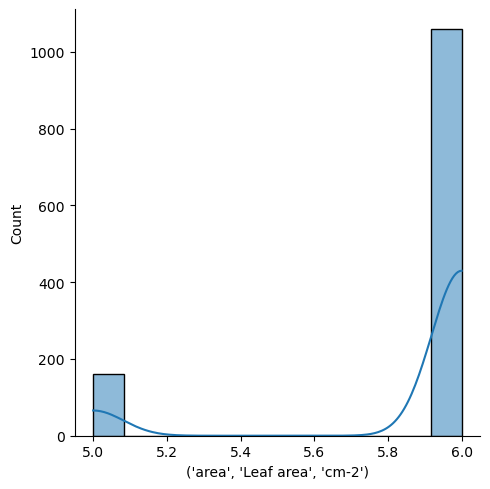

Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1')


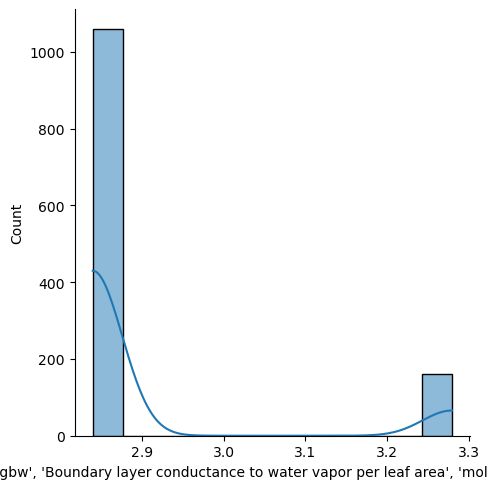

Visualizing ('record', 'Observation record number', 1)


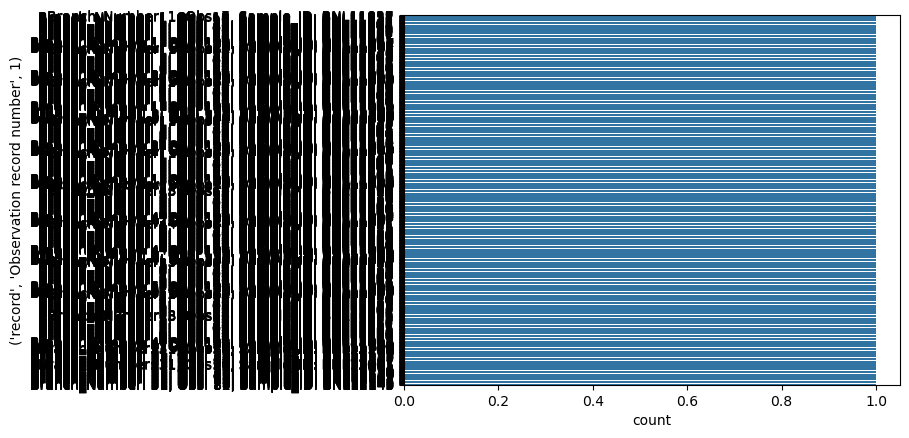

Visualizing ('CO2r', 'CO2 concentration in wet air entering chamber', 'μmol mol-1')


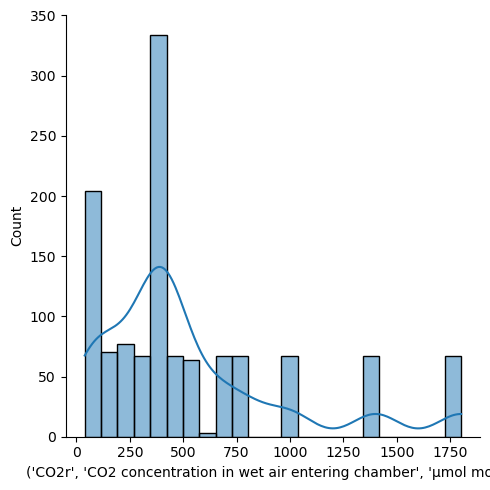

Visualizing ('CO2s', 'CO2 concentration in wet air inside chamber', 'μmol mol-1')


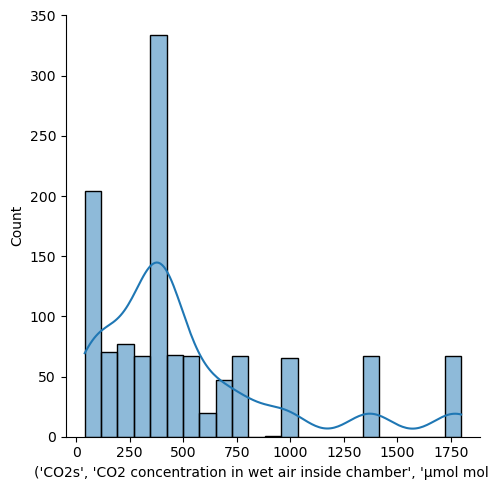

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


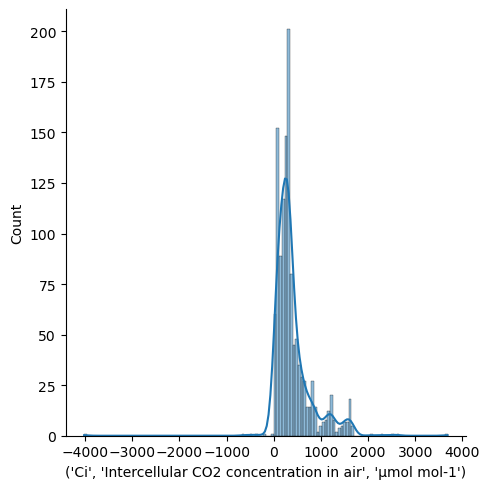

Visualizing ('CiCa', 'Ratio of intercellular CO2 to sample chamber CO2', 1)


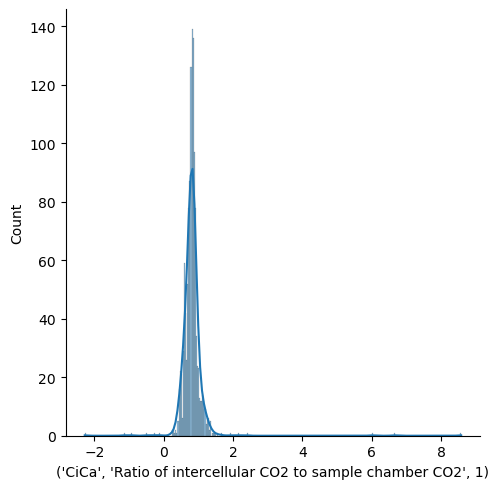

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1')


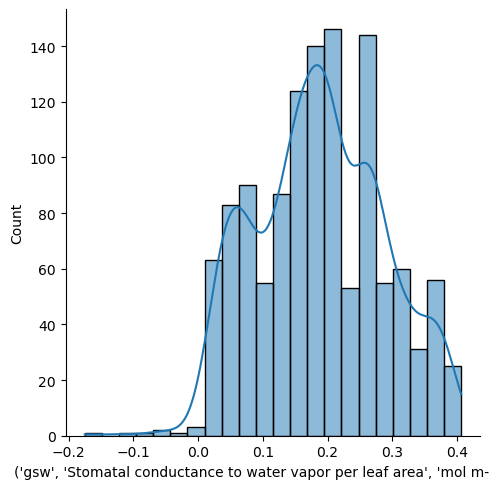

Visualizing ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1)


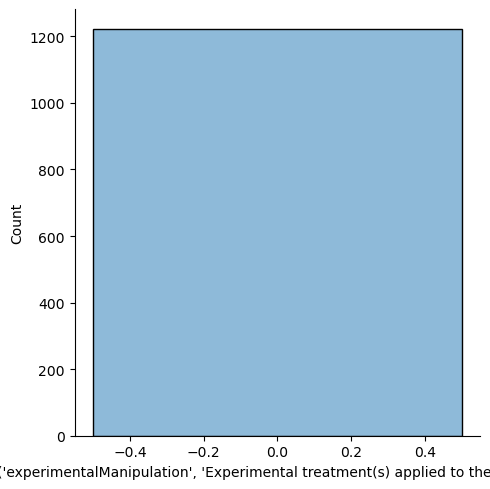

Visualizing ('flow', 'Flow rate of air into chamber', 'μmol s-1')


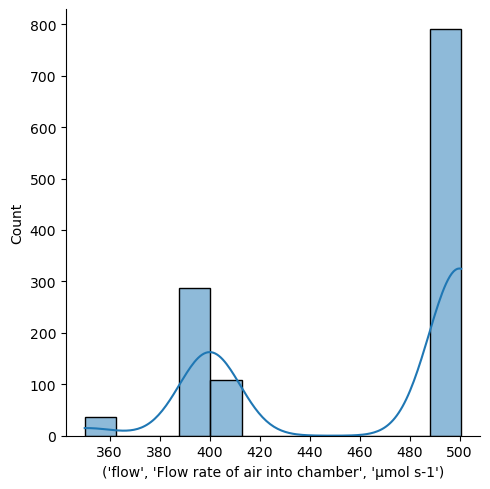

Visualizing ('time', 'Time of observation', 1)


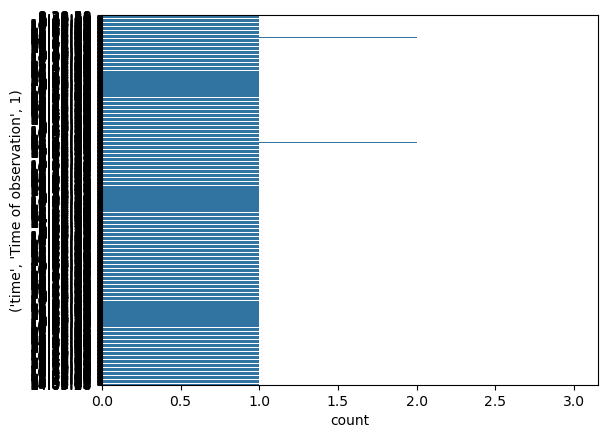

Visualizing ('measurementDevice', 'Name of the instrument that collected data', 1)


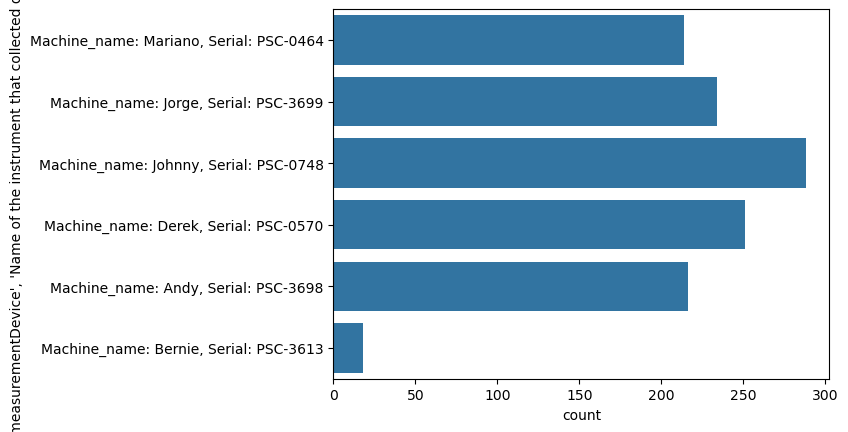

Visualizing ('Qin', 'In-chamber photosynthetic flux density (PPFD) incident on the leaf, quanta per area', 'μmol m-2 s-1')


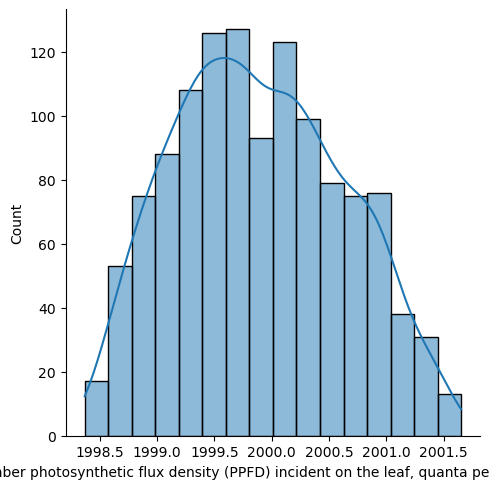

Visualizing ('Qout', 'External photosynthetic flux density (PPFD), quanta per area', 'μmol m-2 s-1')


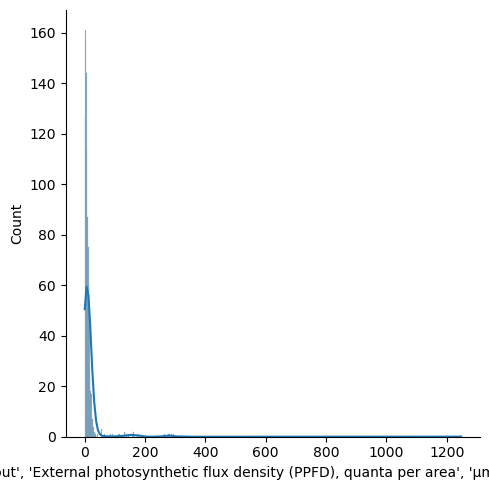

Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


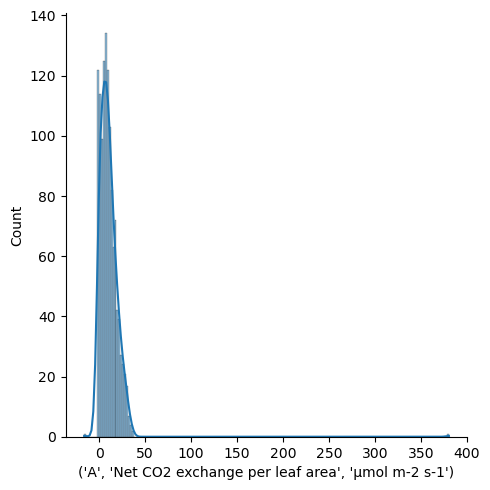

Visualizing ('Patm', 'Atmospheric pressure of the air', 'kPa')


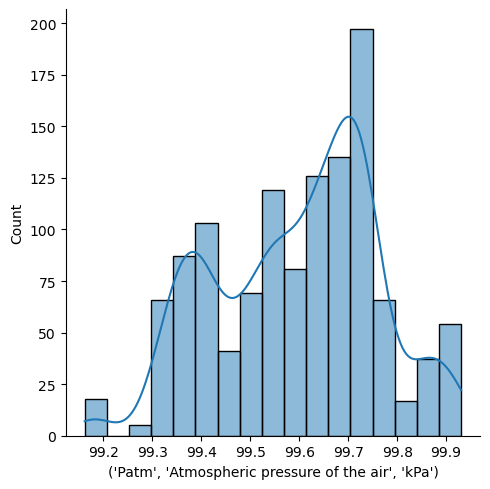

Visualizing ('RHr', 'Relative humidity of air entering the chamber', '%')


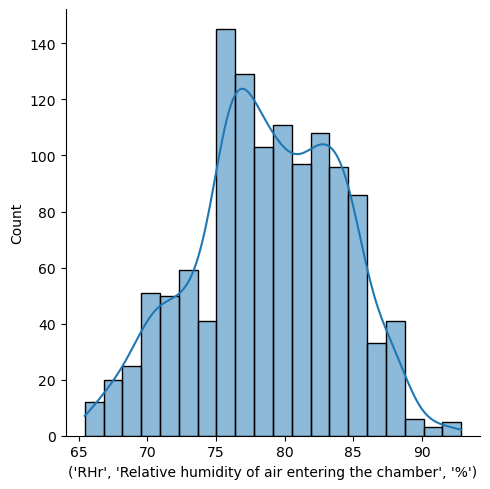

Visualizing ('RHs', 'Relative humidity of air inside the chamber', '%')


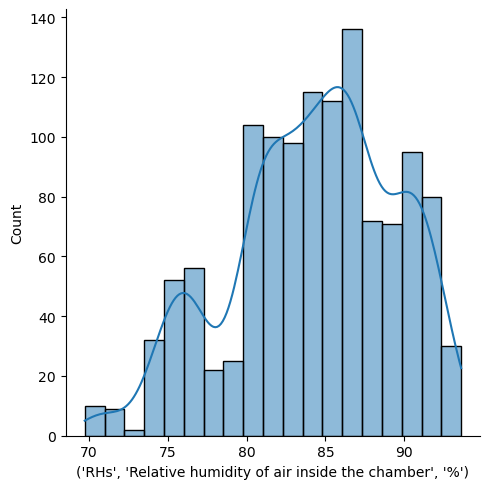

Visualizing ('siteIdentifier', 'Location descriptor of where data was collected', 1)


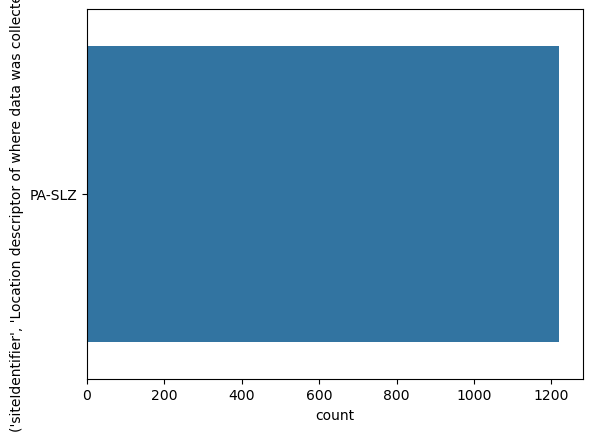

Visualizing ('speciesCode', 'Code used to identify species in data tables', 1)


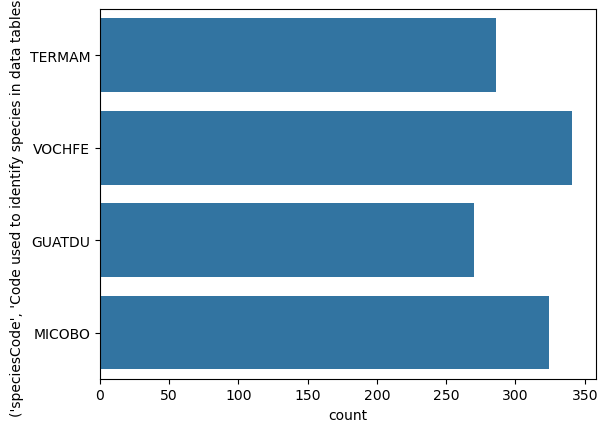

Visualizing ('Tblock', 'Temperature of cooler block used to stabilize air temperature', 'degree_C')


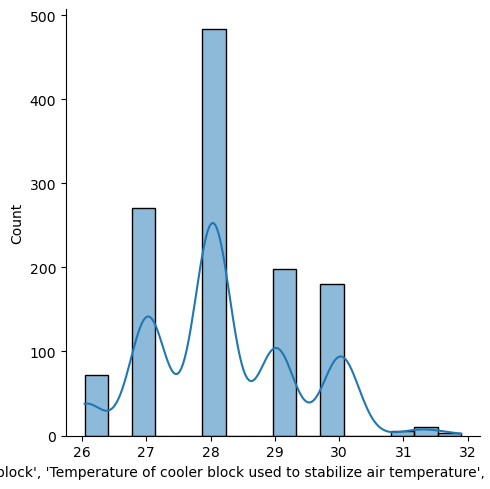

Visualizing ('Tair', 'Air temperature inside the chamber', 'degree_C')


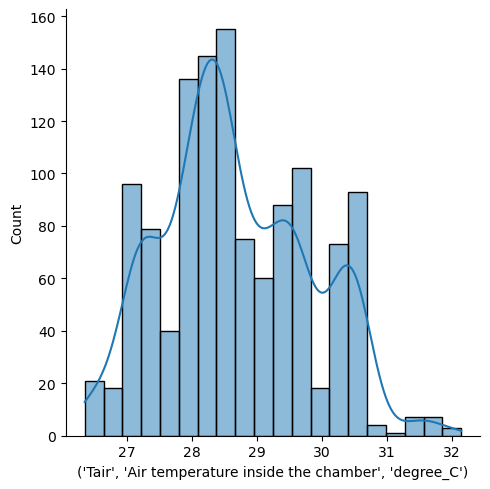

Visualizing ('Tleaf', 'Leaf surface temperature', 'degree_C')


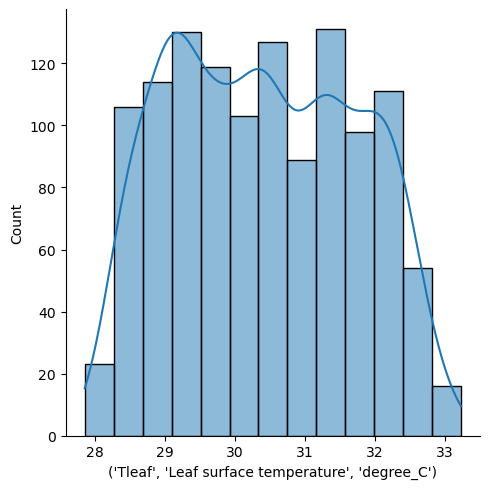

Visualizing ('E', 'Transpiration rate of H2O per leaf area', 'mmol m-2 s-1')


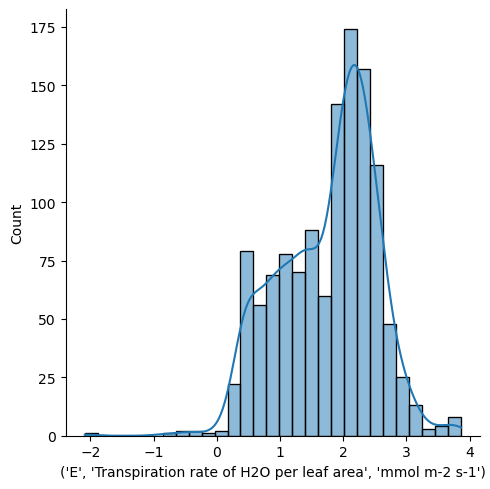

Visualizing ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa')


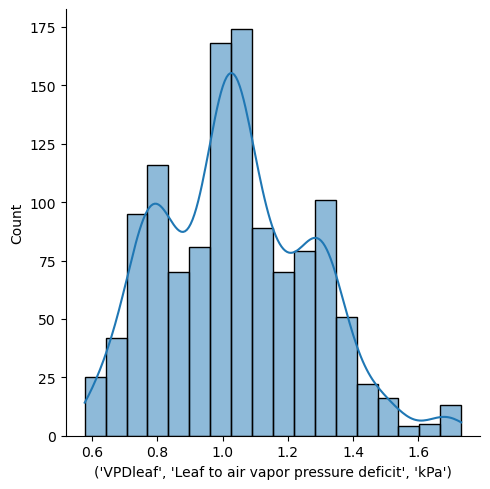

Visualizing ('date', 'Date of observation', 1)


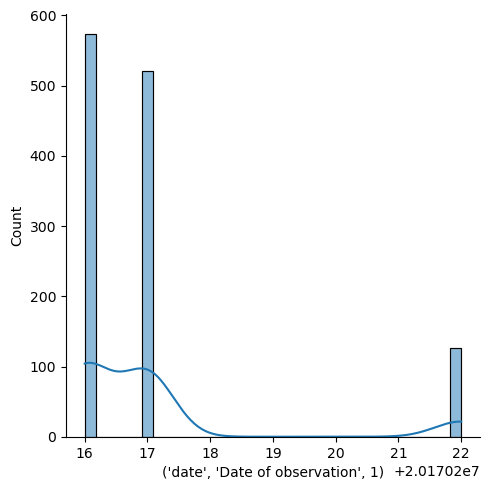

In [29]:
# Iterate over filtered_standard_data columns and visualize
for col in filtered_standard_data.columns:
    print(f"Visualizing {col}")
    funcs.visualize_all_columns(filtered_standard_data[col])

---
---
## 4. Quality Control
---
### 4.1. Strings

In [30]:
# general string cleaning
def clean_string_columns(df):
    # Select only object (string) dtype columns
    string_columns = df.select_dtypes(include=['object']).columns
    df.loc[:, string_columns] = df.loc[:, string_columns].apply(lambda col: col.str.strip().str.lower().str.replace('_', ' '))
    return df

# Apply the function to your DataFrame
filtered_standard_data = clean_string_columns(filtered_standard_data)

In [31]:
# Replace specific values with None
values_to_replace = [-999, -9999, 'none', 'None', np.nan]
filtered_standard_data = filtered_standard_data.replace(values_to_replace, None)

---
### 4.2. Measurement device
Current measurement device column tells who used the instrument. Needs to be chaned.

In [32]:
# replace measurement device column with actual device name
device = 'licor 6400'
filtered_standard_data[('measurementDevice', 'Name of the instrument that collected data', 1)] = device

---
### 4.3. Season
This should be calculated where possible

---
### 4.4 Plant height
Not recorded

---
### 4.x. Plant form
Not recorded

---
### 4.x. Data contributor
This data was collected by one team

In [33]:
# set contributor name
filtered_standard_data[('dataContributor',
                        'Name of the individual or organization that contributed to the data',
                        1)] = 'Alistair Rogers (NGEE Tropics)'

---
### 4.x. Environmental manipulation

In [34]:
filtered_standard_data[('experimentalManipulation', 
                        'Experimental treatment(s) applied to the plant', 
                        1)] = 'ambient'

---
### 4.x. Growth environment

In [35]:
filtered_standard_data[('growthEnvironment', 
                        'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 
                        1)] = 'open'

---
### 4.x. longitudeX

In [37]:
# data was collected using a crane
# coordinates of crain found at https://striresearch.si.edu/physical-monitoring/san-lorenzo/
filtered_standard_data[('longitudeX', 
                        'Longitude coordinate of the site', 
                        'degree')] = -79.974520

---
### 4.x. latitudeY

In [38]:
# data was collected using a crane
# coordinates of crain found at https://striresearch.si.edu/physical-monitoring/san-lorenzo/
filtered_standard_data[('latitudeY', 
                        'Latitude coordinate of the site', 
                        'degree')] = 9.281031

---
### 4.5. Dates/Times

#### A. If you have a ton of different datetime formats to contend with:
* Create a .csv `../data/temp/datetmes/{filename}_datetime_formatting.csv` with headers `source`, `datetime_formats`, `time_formats`, and `dayfirst`
* Assign a list of datetime formats, time formats, and dayfirst info (whether or not the date starts with a day) in `{filename}_datetime_formatting.csv`
    * Assign these special cases where necessary:
        * decimal_hours (time is in decimal hours), total_minutes (time is in total minutes), date_with_time (date contains time information), range_of_days (date is a range of days, e.g., 1-2 September 2024)
        * add more special case handling in the `funcs.process_datetime()` as needed
* Export filled in `../data/temp/datetmes/{filename}_datetime_formatting.csv` as `../data/temp/datetmes/{filename}_datetime_formatting_01.csv`
<\b>

#### B. If you only have one datetime format, you can just set it here

In [39]:
filtered_standard_data[('date', 'Date of observation', 1)].unique()

array([20170216, 20170217, 20170222])

In [40]:
filtered_standard_data[('time', 'Time of observation', 1)].unique()

array(['8:28:28', '8:29:50', '8:31:12', ..., '14:05:08', '14:07:27',
       '14:09:04'], dtype=object)

In [41]:
# Extract the date column
date_column = filtered_standard_data[('date', 'Date of observation', 1)]

# Convert the date strings to datetime objects for easier processing
date_column = pd.to_datetime(date_column, format='%Y%m%d')

# Add the new columns
filtered_standard_data[('year', 'Year of observation', 1)] = date_column.dt.year
filtered_standard_data[('month', 'Month of observation', 1)] = date_column.dt.month
filtered_standard_data[('day', 'Day of observation', 1)] = date_column.dt.day

---
### 4.6. Species names
There is no species name column, just species codes. They describe them as "STRI" species codes.

In [42]:
filtered_standard_data[('speciesCode', 
                        'Code used to identify species in data tables', 
                        1)].unique()

array(['termam', 'vochfe', 'guatdu', 'micobo'], dtype=object)

In [43]:
# connect species code to a species name
sp_info = pd.read_csv(f'../data/input/{filename}/rogers_species_names.txt', delimiter='\t')
sp_info['species_name'] = sp_info['genus'] + ' ' + sp_info['species']
sp_info = sp_info[['spcode', 'species_name']]
sp_info['spcode'] = sp_info['spcode'].str.lower()

# make multi-header df
columns = [('speciesCode', 'Code used to identify species in data tables', 1), ('species', 'Full species name and subspecies if applicable', 1)]
multi_columns = pd.MultiIndex.from_tuples(
    columns, 
    names=['variable', 'description', 'unit']
)
sp_info.columns = multi_columns
sp_info

variable,speciesCode,species
description,Code used to identify species in data tables,Full species name and subspecies if applicable
unit,1,1
0,*,Unidentified species
1,acacme,Acacia melanoceras
2,acaldi,Acalypha diversifolia
3,aegipa,Aegiphila panamensis
4,alch3,Alchornea sp.3
...,...,...
234,vismma,Vismia macrophylla
235,vochfe,Vochysia ferruginea


In [44]:
# Define the key as the multi-index tuple you want to join on
key = ('speciesCode', 'Code used to identify species in data tables', 1)

# Set the key column as the index in both dataframes
fsd = filtered_standard_data.set_index(key)
si = sp_info.set_index(key)

# Perform the join (left join keeps all rows from filtered_standard_data)
filtered_standard_data2 = fsd.join(si, how='left', rsuffix='_sp_info')

# Optionally, reset the index if you want the merge key as a column again
filtered_standard_data2.reset_index(inplace=True)

In [45]:
# instantiate species checklist
u_species = filtered_standard_data2[[('species', 'Full species name and subspecies if applicable', 1)]].drop_duplicates()
u_species.columns = u_species.columns.get_level_values(0)
u_species = u_species.rename(columns={'species':'unadjudicatedName'})
u_species = u_species.sort_values(by='unadjudicatedName')
u_species

,unadjudicatedName
268,Guatteria dumetorum
322,Miconia minutiflora
0,Terminalia amazonia
214,Vochysia ferruginea


---
### 4.7. Instantiate the species lookup table as `filename_species_lookup.csv`

In [46]:
# add missing columns
u_species['plantType'] = None
u_species['plantLeaf'] = None
u_species['plantForm'] = None
u_species['acceptedName'] = None
u_species['nameAuthor'] = None
u_species['nameAuthority'] = None
u_species['nameCategory'] = None
u_species['nameAdjudicator'] = None

# export checklist
u_species.to_csv(f'../data/temp/species/{filename}_species_lookup.csv')

---
### 4.8. Fill in the lookup table information save as `filename_species_lookup_01.csv`
We recommend passing this task on to an expert who can parse through synonymous, mispelled, and misapplied names

In [47]:
# load edited species checklist (species_checklist_01)
species_checklist = pd.read_csv(f'../data/temp/species/{filename}_species_lookup_01.csv', index_col=0)
species_checklist = species_checklist.replace({np.nan: None})
species_checklist

,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
268,Guatteria dumetorum,angiosperm,evergreen,tree,Guatteria dumetorum,None,None,None,None
322,Miconia minutiflora,angiosperm,evergreen,shrub,Miconia minutiflora,None,None,None,None
0,Terminalia amazonia,angiosperm,deciduous,tree,Terminalia amazonia,None,None,None,None
214,Vochysia ferruginea,angiosperm,deciduous,tree,Vochysia ferruginea,None,None,None,None


#### 4.8.1. Format the lookup table headers for merging new columns to the data

In [48]:
# make single headers into multi-headers
new_columns = pd.MultiIndex.from_tuples([
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1),  # Matching the multi-header in filtered_standard_data2
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1),
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1),
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1),
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1),
    ('nameAuthor', 'The author of the accepted species name', 1),
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1),
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1),
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1)
])
species_checklist.columns = new_columns

#### 4.8.2. Merge the species data to filtered_standard_data

In [49]:
# merge checklist to filtered_standard_data
merged_df = pd.merge(
    filtered_standard_data2,
    species_checklist,
    left_on=[('species', 'Full species name and subspecies if applicable', 1)],
    right_on=[('unadjudicatedName', 'Full species name and subspecies if applicable', 1)],
    how='left'
)
merged_df.head(3)

,speciesCode,area,gbw,record,CO2r,CO2s,Ci,CiCa,gsw,experimentalManipulation,...,species,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Code used to identify species in data tables,Leaf area,Boundary layer conductance to water vapor per leaf area,Observation record number,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Ratio of intercellular CO2 to sample chamber CO2,Stomatal conductance to water vapor per leaf area,Experimental treatment(s) applied to the plant,...,Full species name and subspecies if applicable,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,1,cm-2,mol m-2 s-1,1,μmol mol-1,μmol mol-1,μmol mol-1,1,mol m-2 s-1,1,...,1,1,1,1,1,1,1,1,1,1
0,termam,6,2.84,"branch number: 1, obs: 7, sample id: bnl11837",250.121826,241.266007,183.434017,0.760298,0.215466,ambient,...,Terminalia amazonia,Terminalia amazonia,angiosperm,deciduous,tree,Terminalia amazonia,None,None,None,None
1,termam,6,2.84,"branch number: 1, obs: 8, sample id: bnl11837",175.021271,169.605957,134.618800,0.793715,0.217993,ambient,...,Terminalia amazonia,Terminalia amazonia,angiosperm,deciduous,tree,Terminalia amazonia,None,None,None,None
2,termam,6,2.84,"branch number: 1, obs: 9, sample id: bnl11837",100.029228,98.224739,86.790520,0.883591,0.222568,ambient,...,Terminalia amazonia,Terminalia amazonia,angiosperm,deciduous,tree,Terminalia amazonia,None,None,None,None


In [64]:
# set dtypes
column_data_types = {
    ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1'): 'Float64',
    ('E', 'Transpiration rate of H2O per leaf area', 'mmol m-2 s-1'): 'Float64',
    ('Patm', 'Atmospheric pressure of the air', 'kPa'): 'Float64',
    ('Qin', 'In-chamber photosynthetic flux density (PPFD) incident on the leaf, quanta per area', 'μmol m-2 s-1'): 'Float64',
    ('RHs', 'Relative humidity of air inside the chamber', '%'): 'Float64',
    ('Tair', 'Air temperature inside the chamber', 'degree_C'): 'Float64',
    ('Tleaf', 'Leaf surface temperature', 'degree_C'): 'Float64',
    ('VPDleaf', 'Leaf to air vapor pressure deficit', 'kPa'): 'Float64',
    ('acceptedName', 'The accepted species name assigned by the adjudicator', 1): 'str',
    ('dataContributor', 'Name of the individual or organization that contributed to the data', 1): 'str',
    ('day', 'Day of observation', 1): 'Int64',
    ('experimentalManipulation', 'Experimental treatment(s) applied to the plant', 1): 'str',
    ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1'): 'Float64',
    ('growthEnvironment', 'Growth conditions of the plant, indicating whether it is growing under ambient (normal) or stressed conditions', 1): 'str',
    ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1'): 'Float64',
    ('latitudeY', 'Latitude coordinate of the site', 'degree'): 'Float64',
    ('longitudeX', 'Longitude coordinate of the site', 'degree'): 'Float64',
    ('measurementDevice', 'Name of the instrument that collected data', 1): 'str',
    ('month', 'Month of observation', 1): 'Int64',
    ('nameAdjudicator', 'The expert that assigned an unadjudicated species name to an accepted species name', 1): 'str',
    ('nameAuthor', 'The author of the accepted species name', 1): 'str',
    ('nameAuthority', 'The authority that was referenced to assign the accepted species name', 1): 'str',
    ('nameCategory', 'The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)', 1): 'str',
    ('plantForm', 'Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function', 1): 'str',
    ('plantLeaf', 'Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns', 1): 'str',
    ('plantType', 'Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage', 1): 'str',
    ('siteIdentifier', 'Location descriptor of where data was collected', 1): 'str',
    ('time', 'Time of observation', 1): 'str',
    ('unadjudicatedName', 'Full species name and subspecies if applicable', 1): 'str',
    ('year', 'Year of observation', 1): 'Int64'
}

In [65]:
# assign data types
merged_df = merged_df.astype(column_data_types)
merged_df.head(3)

,speciesCode,area,gbw,record,CO2r,CO2s,Ci,CiCa,gsw,experimentalManipulation,...,species,unadjudicatedName,plantType,plantLeaf,plantForm,acceptedName,nameAuthor,nameAuthority,nameCategory,nameAdjudicator
,Code used to identify species in data tables,Leaf area,Boundary layer conductance to water vapor per leaf area,Observation record number,CO2 concentration in wet air entering chamber,CO2 concentration in wet air inside chamber,Intercellular CO2 concentration in air,Ratio of intercellular CO2 to sample chamber CO2,Stomatal conductance to water vapor per leaf area,Experimental treatment(s) applied to the plant,...,Full species name and subspecies if applicable,Full species name and subspecies if applicable,"Classification of plant as either gymnosperm or angiosperm, indicating differences in reproductive structures and evolutionary lineage","Leaf lifespan strategy of the plant, categorizing it as evergreen or deciduous based on leaf retention patterns","Life form of the plant, categorizing it as tree, shrub, grass, crop, savanna, etc., based on growth form and ecological function",The accepted species name assigned by the adjudicator,The author of the accepted species name,The authority that was referenced to assign the accepted species name,"The taxonomic heirarchy level at which the plant was named (family, genus, species, subspecies, variety, type)",The expert that assigned an unadjudicated species name to an accepted species name
,1,cm-2,mol m-2 s-1,1,μmol mol-1,μmol mol-1,μmol mol-1,1,mol m-2 s-1,1,...,1,1,1,1,1,1,1,1,1,1
0,termam,6,2.84,"branch number: 1, obs: 7, sample id: bnl11837",250.121826,241.266007,183.434017,0.760298,0.215466,ambient,...,Terminalia amazonia,Terminalia amazonia,angiosperm,deciduous,tree,Terminalia amazonia,None,None,None,None
1,termam,6,2.84,"branch number: 1, obs: 8, sample id: bnl11837",175.021271,169.605957,134.618800,0.793715,0.217993,ambient,...,Terminalia amazonia,Terminalia amazonia,angiosperm,deciduous,tree,Terminalia amazonia,None,None,None,None
2,termam,6,2.84,"branch number: 1, obs: 9, sample id: bnl11837",100.029228,98.224739,86.790520,0.883591,0.222568,ambient,...,Terminalia amazonia,Terminalia amazonia,angiosperm,deciduous,tree,Terminalia amazonia,None,None,None,None


---
---
## 5. Unit conversion

In [66]:
# ensure numeric columns are float instead of object dtypes
numeric_cols = []
for col in merged_df.columns:
    try:
        pd.to_numeric(merged_df[col], errors='raise')
        numeric_cols.append(col)
    except ValueError:
        pass  # Skip non-numeric columns

# convert
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').astype('float32')

# replace NaN with None in numeric columns
merged_df[numeric_cols] = merged_df[numeric_cols].map(lambda x: None if pd.isna(x) else x)

In [67]:
# Create a deep copy of merged_df
merged_df_2 = merged_df.copy(deep=True)
merged_df_2, preconverted_cols, converted_cols = funcs.check_and_convert_units(column_standards, merged_df_2)

Mismatch found: gbw (Boundary layer conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Converted data from mol m-2 s-1 to mmol m-2 s-1: min=2839.9999141693115, max=3279.130458831787
Converted units and updated header.
Mismatch found: gsw (Stomatal conductance to water vapor per leaf area) - mol m-2 s-1 to mmol m-2 s-1
Converted data from mol m-2 s-1 to mmol m-2 s-1: min=-175.27194321155548, max=406.53306245803833
Converted units and updated header.


---
### 5.1. Visualize and confirm unit conversions

Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mmol m-2 s-1')


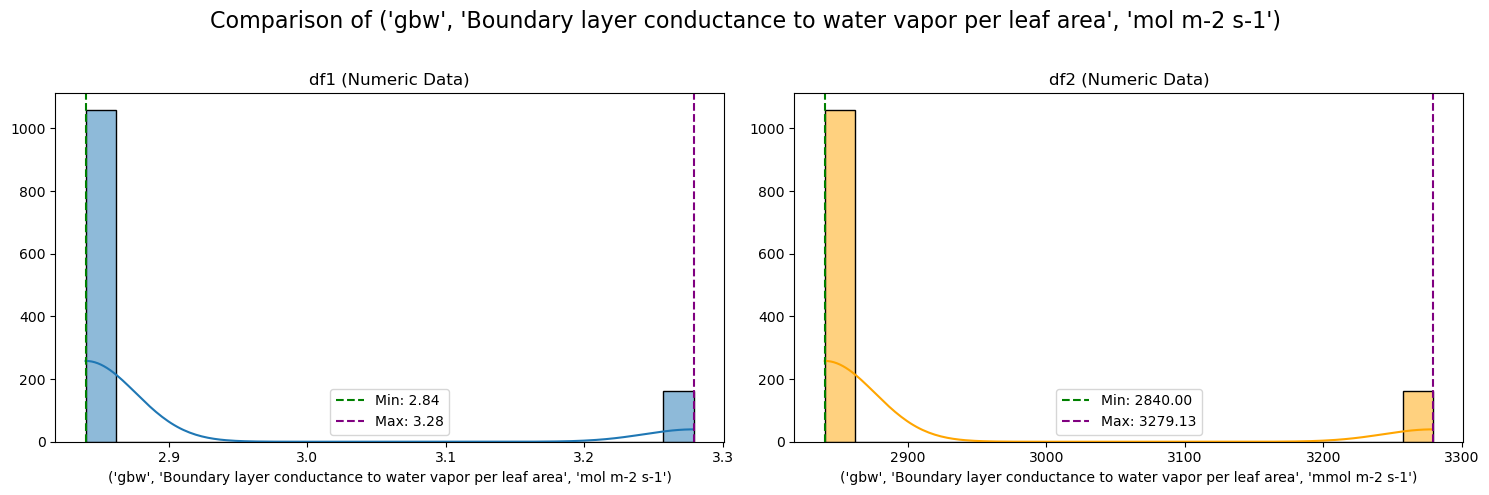

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


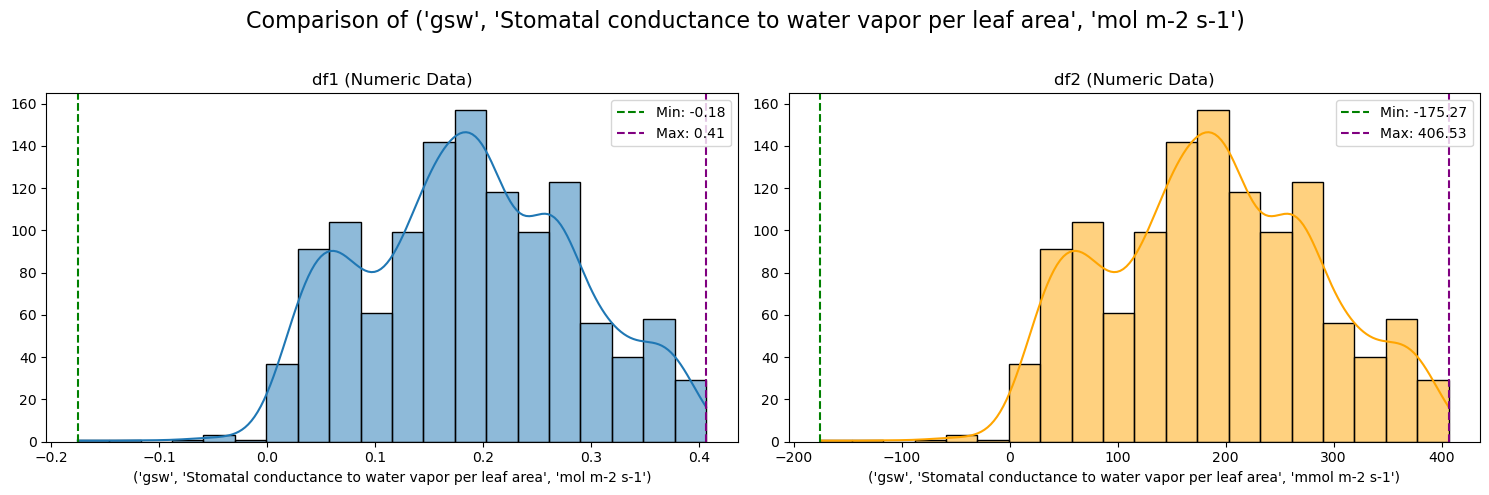

In [68]:
funcs.compare_col_hists(merged_df, preconverted_cols, merged_df_2, converted_cols)

---
### 5.2. Drop out-of-range values per ESS-Dive leaf-gas-exchange info

In [69]:
oor = pd.read_csv('../data/supp/info_measured_variables.csv')
oor

,variableName,variableUnit,variableDescription,expectedValueRangeMin,expectedValueRangeMax
0,date,YYYY-MM-DD,Date of observation,NaN,NaN
1,time,HH:MM:SS,Time of observation,NaN,NaN
2,record,1,Observation record number,NaN,NaN
3,area,cm-2,Leaf area,NaN,NaN
4,A,µmol m-2 s-1,Net CO₂ exchange per leaf area,-20.0,120.0
5,Amax,µmol m-2 s-1,Highest rate of light and CO₂ saturated A,-20.0,120.0
6,Asat,µmol m-2 s-1,Highest rate of light saturated A at ambient C...,-20.0,120.0
7,Ci,µmol mol-1,Intercellular CO₂ concentration in air,0.0,5000.0
8,CO2r,µmol mol-1,CO₂ concentration in wet air entering chamber,0.0,5000.0
9,CO2s,µmol mol-1,CO₂ concentration in wet air inside chamber,0.0,5000.0


In [70]:
# filter out values that are out of acceptable ranges (oor)
filtered_df, oor_cols = funcs.filter_out_of_range_data(oor, merged_df_2)

Match found for variable: date
date count before filtering: 1221, count after filtering: 1221
Match found for variable: time
Skipping non-numeric variable: time
Match found for variable: record
Skipping non-numeric variable: record
Match found for variable: area
area count before filtering: 1221, count after filtering: 1221
Match found for variable: A
A count before filtering: 1221, count after filtering: 1220
No match found for variable: Amax, skipping.
No match found for variable: Asat, skipping.
Match found for variable: Ci
Ci count before filtering: 1221, count after filtering: 1215
Match found for variable: CO2r
CO2r count before filtering: 1221, count after filtering: 1221
Match found for variable: CO2s
CO2s count before filtering: 1221, count after filtering: 1221
No match found for variable: dCO2, skipping.
No match found for variable: dH2O, skipping.
Match found for variable: E
E count before filtering: 1221, count after filtering: 1221
Match found for variable: flow
flow coun

Visualizing ('A', 'Net CO2 exchange per leaf area', 'μmol m-2 s-1')


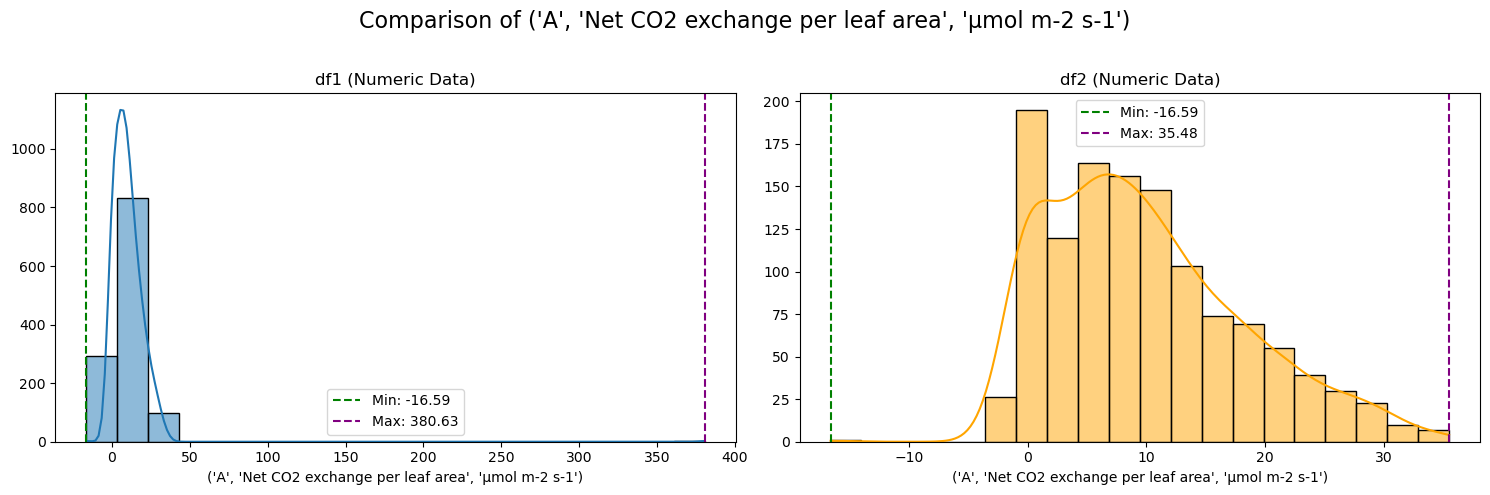

Visualizing ('Ci', 'Intercellular CO2 concentration in air', 'μmol mol-1')


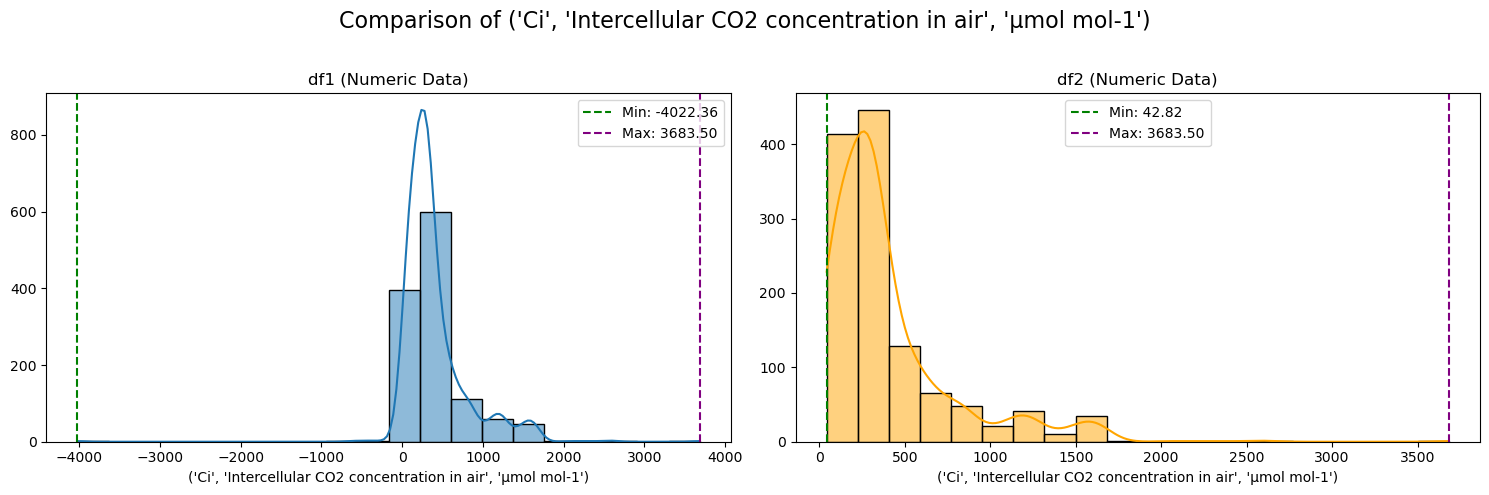

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


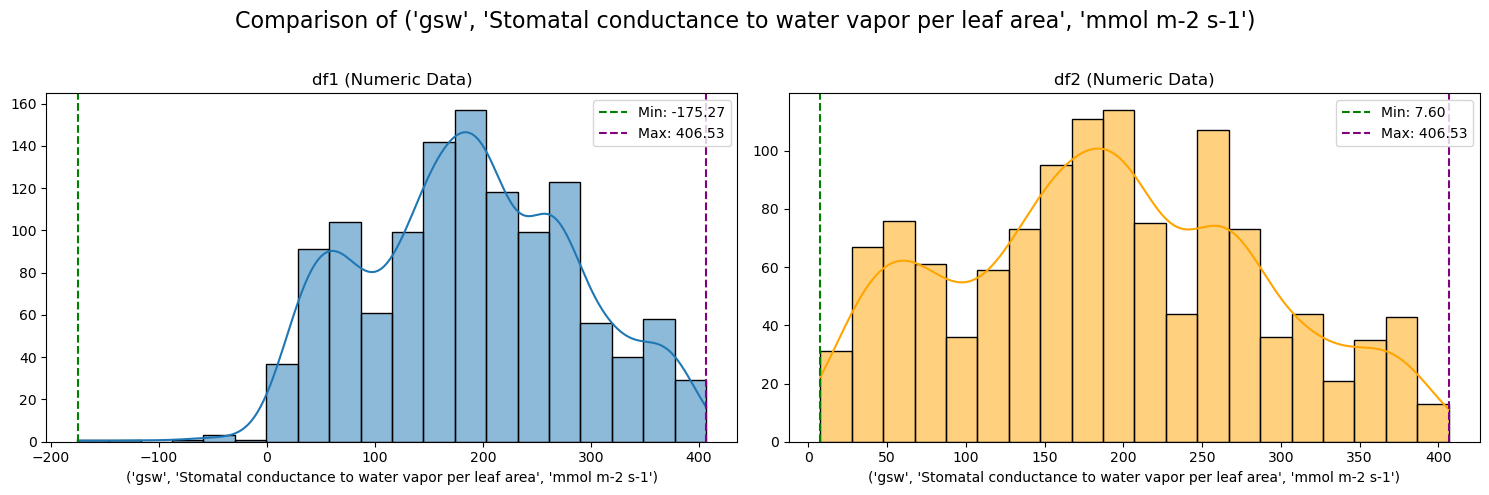

Visualizing ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gbw', 'Boundary layer conductance to water vapor per leaf area', 'mmol m-2 s-1')


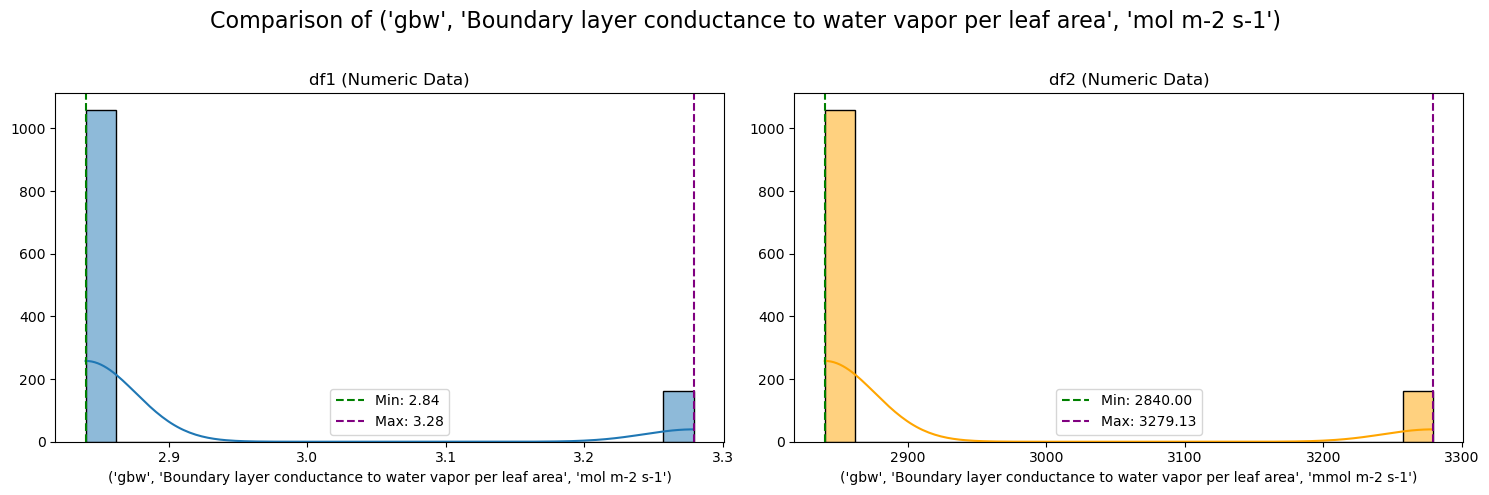

Visualizing ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mol m-2 s-1') and ('gsw', 'Stomatal conductance to water vapor per leaf area', 'mmol m-2 s-1')


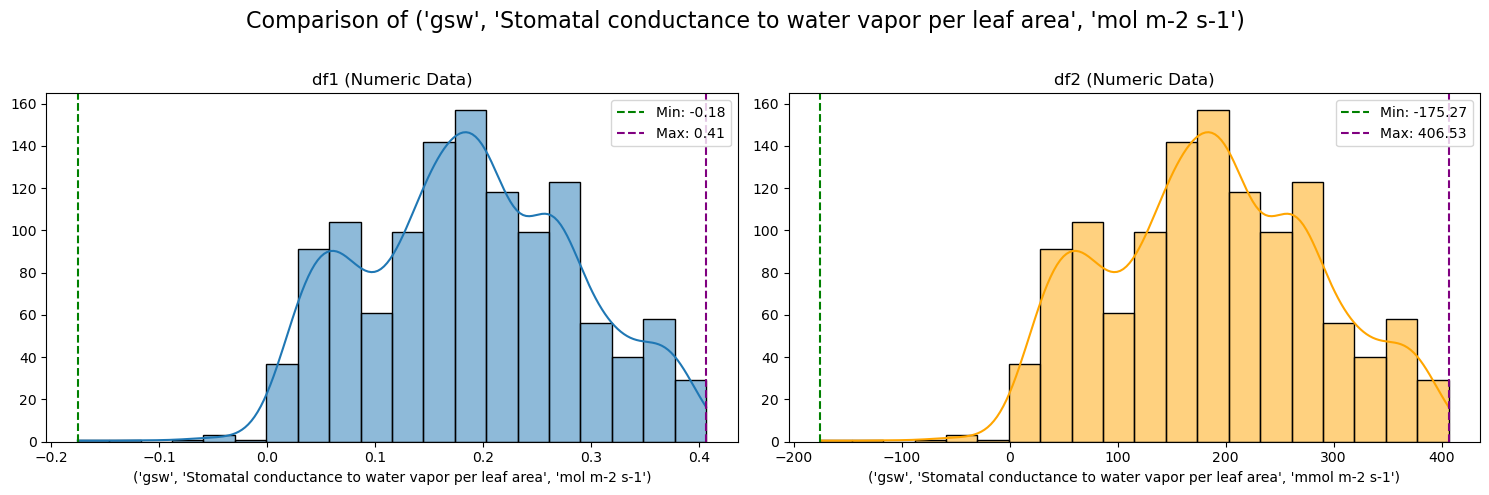

In [71]:
# Now plot the comparison
for oor_col in oor_cols:
    print(f'Visualizing {oor_col}')

    try:
        # Select columns using multi-level tuples
        selected_col_1 = merged_df_2[oor_col].squeeze()
        selected_col_2 = filtered_df[oor_col].squeeze()
        
        # Call the comparison plot function
        funcs._hist_plot_comparison(selected_col_1, selected_col_2, oor_col)

    except Exception as e:
        print('Could not plot...', e)

funcs.compare_col_hists(merged_df, preconverted_cols, merged_df_2, converted_cols)

In [72]:
# export
filtered_df.to_csv(f'../data/output/{filename}.csv', encoding='utf-8-sig')